In [248]:
# load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [249]:
import PIL

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Loading the train data

In [250]:
train_data = 'data\\plates\\train'

In [251]:
test_data = 'data\\plates\\test'

In [252]:
batch_size = 35
img_height = 180
img_width = 180

## Data splitting

In [253]:
train_ds = tf.keras.utils.image_dataset_from_directory( # Using forward slashes
  train_data, # Using forward slashes
  validation_split=0.2, # 20% of the data will be used for validation
  subset="training", # only training data will be used
  seed=123, #  for reproducibility
  image_size=(img_height, img_width), # resize all the images to this size
  batch_size=batch_size) #   batch size

Found 40 files belonging to 2 classes.
Using 32 files for training.


In [254]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_data,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 40 files belonging to 2 classes.
Using 8 files for validation.


In [255]:
class_names = train_ds.class_names
print(class_names)

['cleaned', 'dirty']


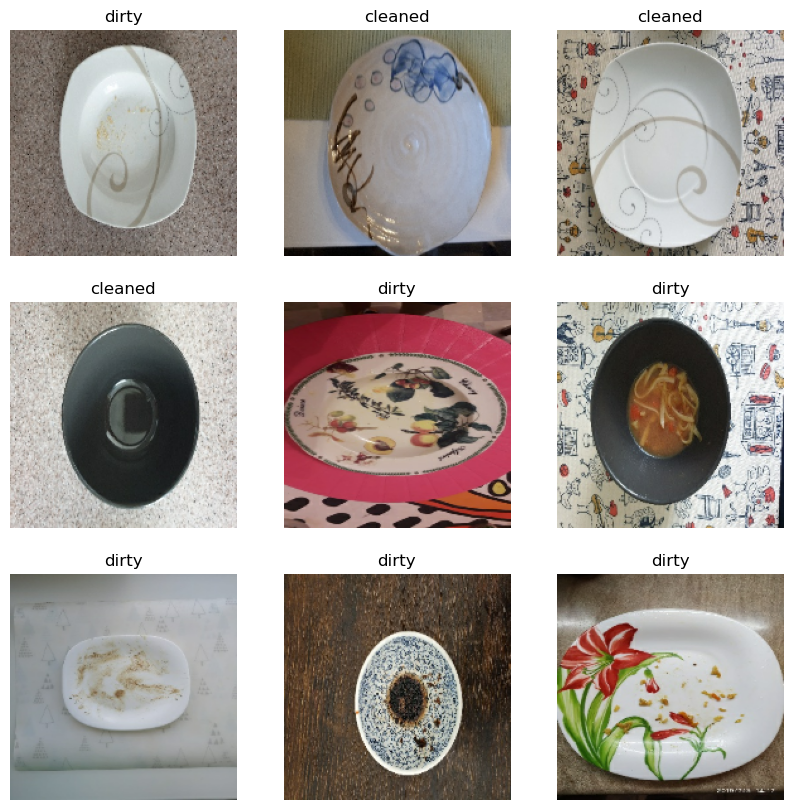

In [256]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [257]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [258]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Normalization

In [259]:
normalization_layer = layers.Rescaling(1./255)

In [260]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


## Data Augmentation

In [261]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal",
                          input_shape=(img_height,
                                       img_width,
                                       3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

c:\Users\Vishaly\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Creating the model

In [262]:
num_classes = len(class_names)

model = Sequential([
  layers.InputLayer(input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

c:\Users\Vishaly\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [263]:
print(np.min(first_image), np.max(first_image))

0.0 1.0


## Training the model

In [264]:
import tensorflow as tf
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Define initial learning rate
initial_learning_rate = 0.001

# Set up exponential decay for the learning rate
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

# Create an Adam optimizer with the learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [265]:
# Compile the model with the custom optimizer and loss function
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [266]:
model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,988,898 (15.22 MB)

 Trainable params: 3,988,898 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [267]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4688 - loss: 8.7599 - val_accuracy: 0.6250 - val_loss: 923.4219
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.4688 - loss: 1331.4937 - val_accuracy: 0.6250 - val_loss: 330.4509
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.4688 - loss: 479.6077 - val_accuracy: 0.3750 - val_loss: 29.5275
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.5625 - loss: 13.1765 - val_accuracy: 0.3750 - val_loss: 82.0208
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.5312 - loss: 49.7074 - val_accuracy: 0.5000 - val_loss: 8.3708


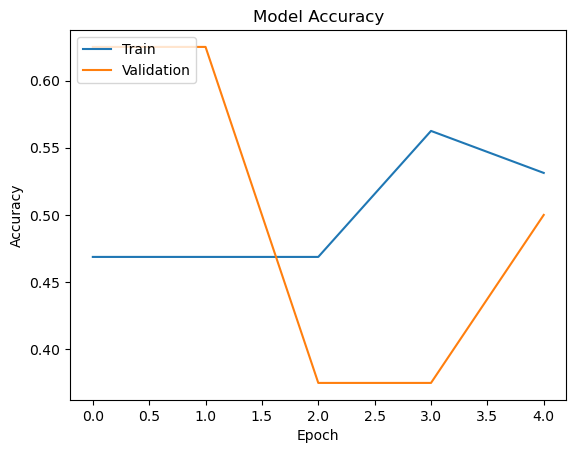

In [268]:
# Plot the training and validation accuracy and loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

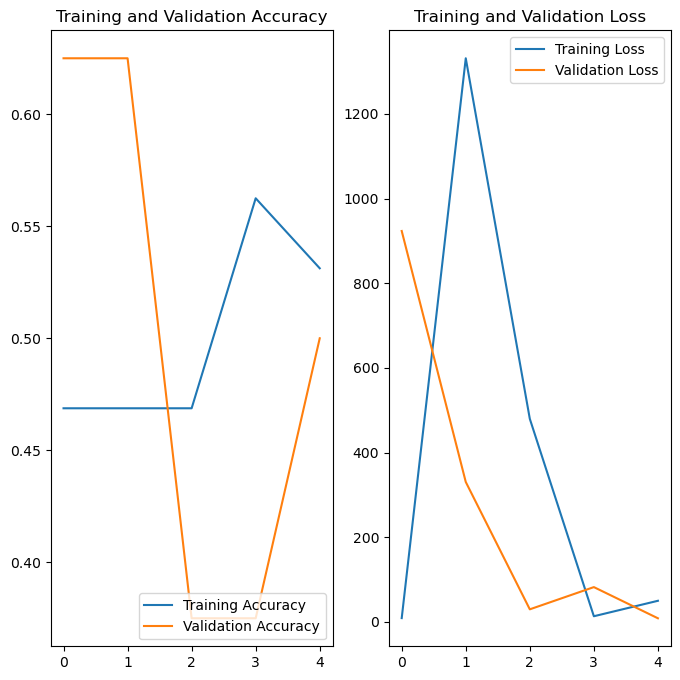

In [269]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [270]:
#train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True) # image augmentation to avoid overfitting

In [271]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  labels = 'inferred',
  label_mode = None,
  color_mode = 'rgb',
  shuffle = False
)

Found 744 files.


In [272]:
# use the trained model
y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step


In [273]:
y_pred

array([0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,

## Submission

In [274]:
import os
test_files = os.listdir(test_data)
print(test_files)

['0000.jpg', '0001.jpg', '0002.jpg', '0003.jpg', '0004.jpg', '0005.jpg', '0006.jpg', '0007.jpg', '0008.jpg', '0009.jpg', '0010.jpg', '0011.jpg', '0012.jpg', '0013.jpg', '0014.jpg', '0015.jpg', '0016.jpg', '0017.jpg', '0018.jpg', '0019.jpg', '0020.jpg', '0021.jpg', '0022.jpg', '0023.jpg', '0024.jpg', '0025.jpg', '0026.jpg', '0027.jpg', '0028.jpg', '0029.jpg', '0030.jpg', '0031.jpg', '0032.jpg', '0033.jpg', '0034.jpg', '0035.jpg', '0036.jpg', '0037.jpg', '0038.jpg', '0039.jpg', '0040.jpg', '0041.jpg', '0042.jpg', '0043.jpg', '0044.jpg', '0045.jpg', '0046.jpg', '0047.jpg', '0048.jpg', '0049.jpg', '0050.jpg', '0051.jpg', '0052.jpg', '0053.jpg', '0054.jpg', '0055.jpg', '0056.jpg', '0057.jpg', '0058.jpg', '0059.jpg', '0060.jpg', '0061.jpg', '0062.jpg', '0063.jpg', '0064.jpg', '0065.jpg', '0066.jpg', '0067.jpg', '0068.jpg', '0069.jpg', '0070.jpg', '0071.jpg', '0072.jpg', '0073.jpg', '0074.jpg', '0075.jpg', '0076.jpg', '0077.jpg', '0078.jpg', '0079.jpg', '0080.jpg', '0081.jpg', '0082.jpg', '00

In [275]:
# create a submission file
submission = pd.DataFrame({
    'id': [x.split('.')[0] for x in test_files],
    'label': ['clean' if x == 0 else 'dirty' for x in y_pred]
})

submission.head()

,id,label
0,0000,clean
1,0001,dirty
2,0002,dirty
3,0003,dirty
4,0004,dirty


In [276]:
submission.to_csv('submission.csv', index=False, header=True)